# Prepping data

## Imports

Import here the relevant packages we will need for this project.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import re
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit,train_test_split
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,precision_recall_curve


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
set_ = pd.read_csv("train.csv")

## Data cleaning and visualization

In [3]:
print(set_.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Check for missing data, it appears many are missing entries in age and Cabin. Replace age with the median, and replacing nans in Cabin with "Unknown" category. There are a couple missing in Embarked, we will replace those with the most likely embarking point "S".

In [4]:
for col in set_.columns:
    print(set_[col].isna().sum(),col)

0 PassengerId
0 Survived
0 Pclass
0 Name
0 Sex
177 Age
0 SibSp
0 Parch
0 Ticket
0 Fare
687 Cabin
2 Embarked


In [6]:
set_["Age"].fillna(value = set_["Age"].median(),inplace = True)

In [7]:
print(set_["Embarked"].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [8]:
set_["Embarked"].fillna(value = "S", inplace=True)

In [9]:
set_["Cabin"].fillna(value = "Unknown", inplace=True)

We don't really care exactly what room they were staying in, rather the section. 

In [10]:
def map_cabin_to_section(cabin):
    map_list_section = ["A","B","C","D","E","F","T","G","Unknown"]
    section, cnt=[],[]
    for cab in cabin:
        for str_ in map_list_section:
            if cab.find(str_)==0:
                section.append(str_),cnt.append(cab.count(" "))
    return section,cnt

In [11]:
section, number_of_extra_rooms = map_cabin_to_section(set_["Cabin"])
section = pd.DataFrame(data=section,columns=["Section"])
set_=set_.join(section)


In [49]:
def make_dead_alive(data,feature):
    dead, alive =[],[]
    survived = data["Survived"]
    for i in range(len(data[feature])):
        if survived.iloc[i] ==1:
        #alive.append(section.iloc[i])
            alive.append(data[feature].iloc[i])
        else:
            dead.append(data[feature].iloc[i])
    return alive,dead
    

In [50]:
alive , dead = make_dead_alive(set_,"Section")

Let's examine the relationship between cabin section and survival rate. It appears if the passenger's cabin was not labeled the passenger likely did not survive, as well as if the cabin section was known the passenger's survival rate generally increases. Cabin section will serve as a useful feature.

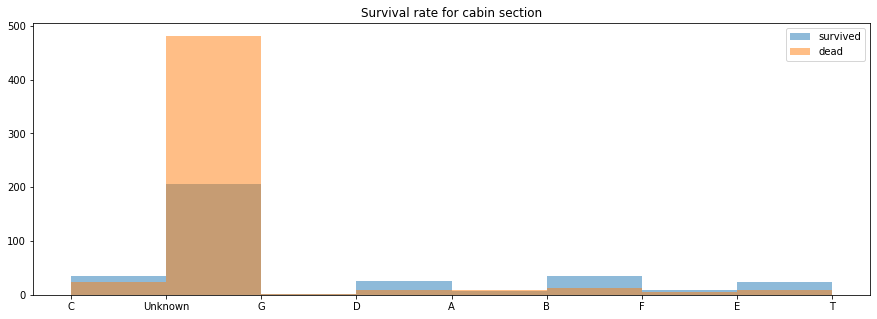

In [52]:
#print(len(dead),len(alive))
#print(dead)
plt.hist(alive,alpha=0.5,bins=range(0,9),label='survived')
plt.hist(dead,alpha=0.5,bins=range(0,9),label='dead')
plt.title("Survival rate for cabin section")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

Create a simple binary feature for if the passenger cabin section is known or not.

In [19]:
def map_cabin_to_section_binary(cabin):
    #map_list_section = ["A","B","C","D","E","F","T","G","Unknown"]
    section=[]
    for cab in cabin:
        if cab.find("Unknown")==0:
            section.append(0)
        else:
            section.append(1)
    return section

In [20]:
section_bin = map_cabin_to_section_binary(set_["Cabin"])
section_bin = pd.DataFrame(data=section_bin,columns=["Sec_bin"])
set_=set_.join(section_bin)

Create a total family count feature.

In [27]:
family_tot = set_["SibSp"]+set_["Parch"]
family_tot = pd.DataFrame(data=family_tot,columns=["Family_total"])
set_=set_.join(family_tot)

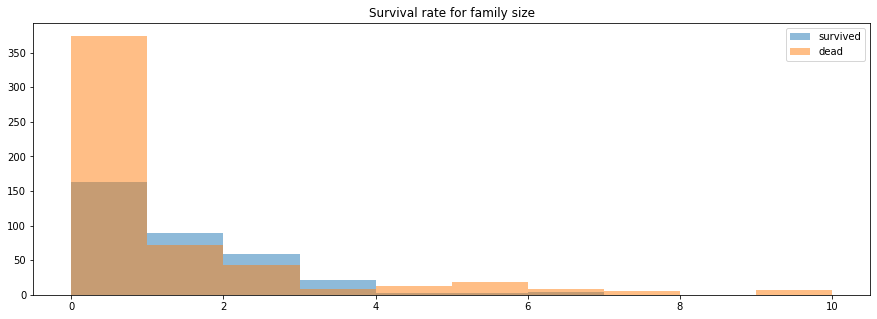

In [53]:
alive, dead = make_dead_alive(set_,"Family_total")
plt.hist(alive,alpha=0.5,bins = range(0,11),label='survived')
plt.hist(dead,alpha=0.5,label='dead')
plt.title("Survival rate for family size")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

Create fare per person feature.

In [55]:
fare_pp = set_["Fare"]/(family_tot["Family_total"]+1)
fare_pp = pd.DataFrame(data=fare_pp,columns=["Fare_pp"])
set_=set_.join(fare_pp)

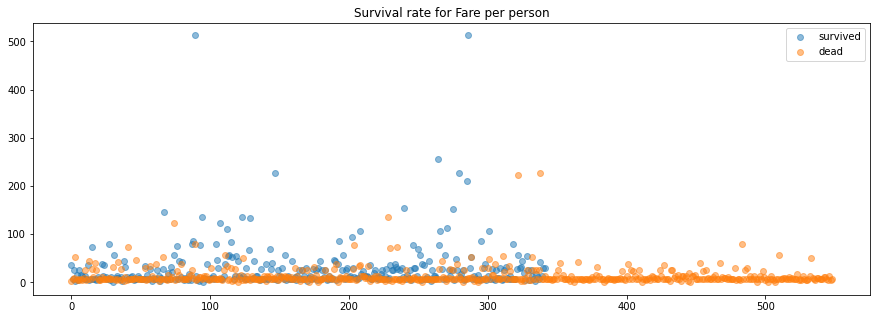

In [59]:
alive, dead = make_dead_alive(set_,"Fare_pp")
plt.scatter(x=range(len(alive)),y=alive,alpha=0.5,label='survived')
plt.scatter(x=range(len(dead)),y=dead,alpha=0.5,label='dead')
plt.title("Survival rate for Fare per person")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

It appears that if the passenger paid more money for their ticket there is a greater probability of survival. Create another feature for the title the passenger has i.e. "Dr" 

In [60]:
title = []
for name in set_["Name"]:
    result = re.search(', (.*).',name)
    title_ = result.group(1).split(' ')[0][:-1]
    #print(title_,"||",name)
    title.append(title_)
title = pd.DataFrame(data=title,columns=["Title"])
set_=set_.join(title)


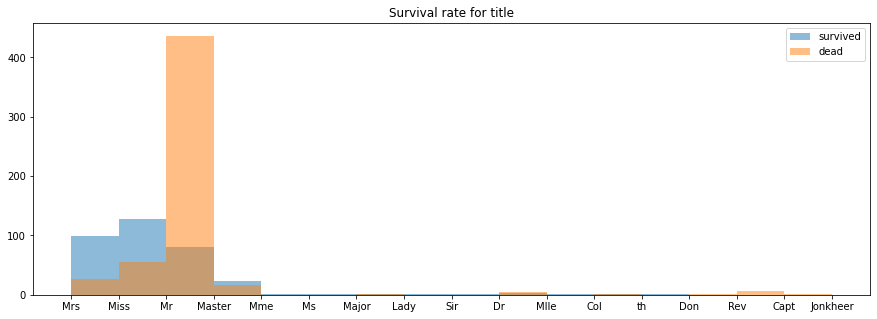

In [75]:
alive, dead = make_dead_alive(set_,"Title")
plt.hist(alive,alpha=0.5,bins=range(17),label='survived')
plt.hist(dead,alpha=0.5,bins=range(17),label='dead')
plt.title("Survival rate for title")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

<AxesSubplot:>

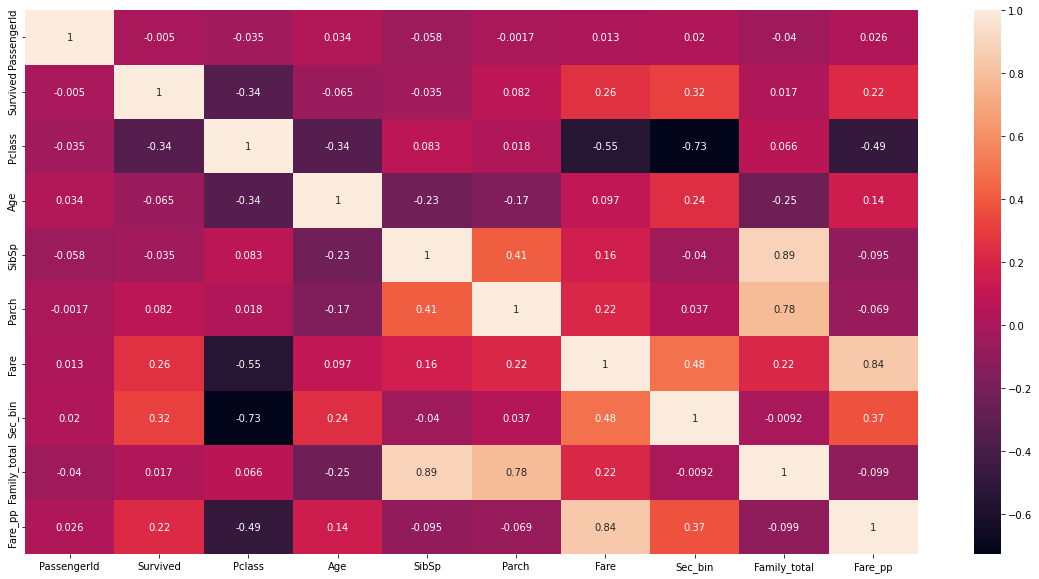

In [61]:
plt.figure(figsize = (20,10))
sns.heatmap(set_.corr(),annot = True)

# Fitting the data

In this section we will try to predict passenger survival using a variety of different algorithms. In each subsection we will show the resulting confusion matrix, recall, precision, and accuracy scores for the binary classification. First we will begin by creating a pipeline for the numerical and categorical features. Then create training and test sets.

In [140]:
num_list = ["Pclass","SibSp","Parch","Family_total","Fare_pp"]
one_enc = ["Sex","Sec_bin"]
hot_enc = ["Embarked","Section","Title"]
drop = ["PassengerId","Survived","Name","Cabin","Ticket","Title","Section","Fare"]
pipe = [('standard_scaler',StandardScaler(),num_list),("categorical",OneHotEncoder(),hot_enc),
       ("binary",OrdinalEncoder(),one_enc),('drop','drop',drop)]
#pipe = [("categorical",OneHotEncoder(),hot_enc)]
full_pipe = ColumnTransformer(pipe,remainder='passthrough')
set_new = full_pipe.fit_transform(set_)

In [141]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_ind, test_ind in split.split(set_,survived):
    train_list = train_ind
    test_list = test_ind

train_data, train_result = set_new[train_list],survived[train_list]
test_data, test_result = set_new[test_list],survived[test_list]
#train_data,test_data,train_result,test_result=train_test_split(full_pipe.fit_transform(set_),survived.values,test_size=0.2,random_state=42)

In [243]:
#train_data = full_pipe.fit_transform(train_data)
#test_data=full_pipe.fit_transform(test_data)
def print_model_results(pred,results):
    acc = accuracy_score(results,pred)
    prec = precision_score(results,pred)
    rec = recall_score(results,pred)
    print("Accuracy:",acc)
    print("Precision:",prec)
    print("Recall:",rec)

In [98]:
def plot_prec_recall(p,r,t):
    plt.plot(t,p[:-1],"b--",label="precision")
    plt.plot(t,r[:-1],"g-",label="recall")
    plt.show() 
from sklearn.metrics import roc_curve
fpr,tpr,thresh = roc_curve(test_result,grid_search.predict(test_data))
def plot_roc(fpr,tpr,label):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc='upper left')

## K-neigbors

In [200]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = [{'n_neighbors': [3,4,5,6,7,8,9,10,15,20], 'weights':
  ['distance']}]
k_neigh = KNeighborsClassifier()
grid_search = GridSearchCV(k_neigh, param_grid, cv=3,scoring='accuracy',return_train_score=True,refit=True)
grid_search.fit(train_data,train_result)
#k_neigh.fit(train_data,train_result)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
                          'weights': ['distance']}],
             return_train_score=True, scoring='accuracy')

In [201]:
print(grid_search.best_params_)

{'n_neighbors': 7, 'weights': 'distance'}


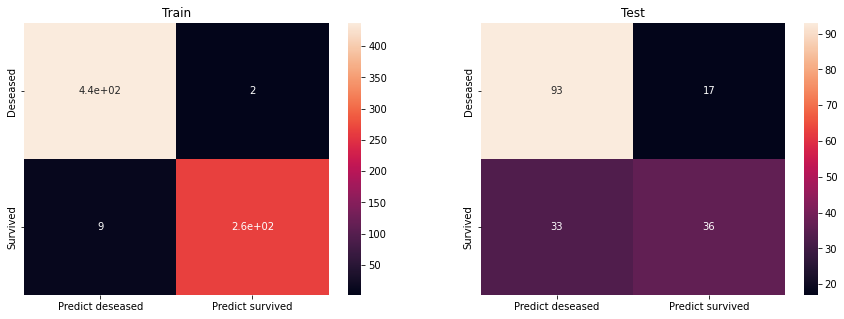

In [202]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train")
ax2.set_title("Test")
sns.heatmap(confusion_matrix(train_result,grid_search.predict(train_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax1);
sns.heatmap(confusion_matrix(test_result,grid_search.predict(test_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax2);

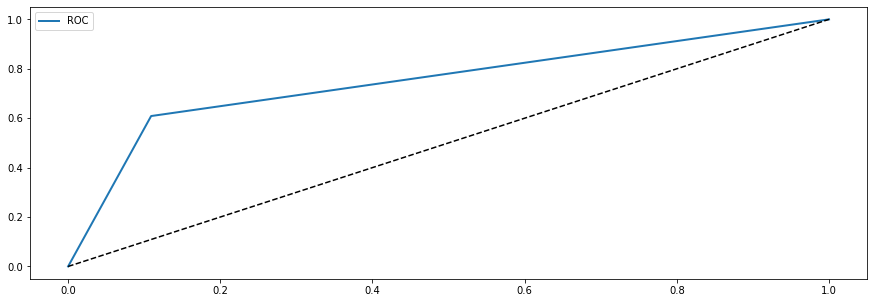

In [146]:
prec, rec, thresh = precision_recall_curve(train_result,grid_search.predict(train_data))
plot_roc(fpr,tpr,"ROC")

In [242]:
print_model_results(grid_search.predict(test_data),test_result)

Accuracy: 0.7206703910614525
Precision: 0.6792452830188679
Recall: 0.5217391304347826


## Random Forest

In [147]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=6, n_estimators=10)
from sklearn.model_selection import cross_validate

param_grid = [{'n_estimators': [3,10,15,20,30,40,50,60,70], 'max_features':
  [2,4,6,8,10,15,20]},{'bootstrap':[False],'n_estimators':[3,10,15,20,30,40,50,60,70],'max_features':
  [2,3,4,6,8,10,12,14,16,18,20]},]

grid_search_rf = GridSearchCV(rf, param_grid, cv=5,scoring='accuracy',return_train_score=True)
grid_search_rf.fit(train_data,train_result)

#cross_validate(rf,train_data,train_result,cv=5)
#grid_search_rf.fit(train_data,train_result)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features=6, n_estimators=10),
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 15, 20],
                          'n_estimators': [3, 10, 15, 20, 30, 40, 50, 60, 70]},
                         {'bootstrap': [False],
                          'max_features': [2, 3, 4, 6, 8, 10, 12, 14, 16, 18,
                                           20],
                          'n_estimators': [3, 10, 15, 20, 30, 40, 50, 60, 70]}],
             return_train_score=True, scoring='accuracy')

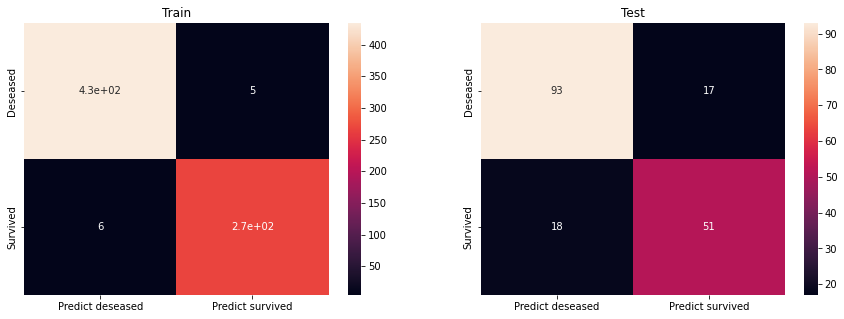

In [185]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train")
ax2.set_title("Test")
sns.heatmap(confusion_matrix(train_result,grid_search_rf.predict(train_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax1);
sns.heatmap(confusion_matrix(test_result,grid_search_rf.predict(test_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax2);

In [150]:
print(grid_search_rf.best_params_)

{'max_features': 15, 'n_estimators': 40}


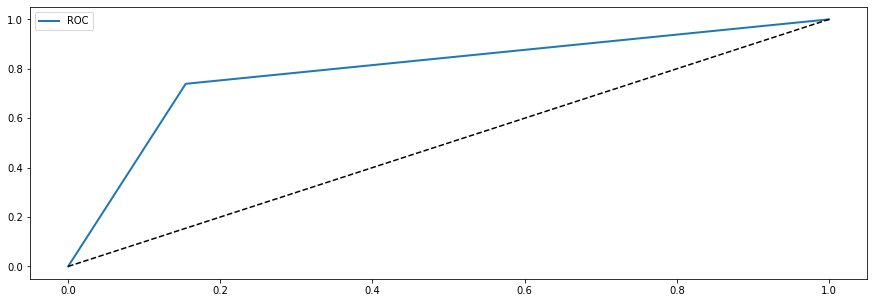

In [151]:
fpr,tpr,thresh = roc_curve(test_result,grid_search_rf.predict(test_data))
plot_roc(fpr,tpr,"ROC")

In [241]:
print_model_results(grid_search_rf.predict(test_data),test_result)

Accuracy: 0.8044692737430168
Precision: 0.75
Recall: 0.7391304347826086


## Support vector classifier

In [154]:
from sklearn.svm import LinearSVC

In [155]:
from sklearn.svm import SVC
#svc = SVC(C=1e4,kernel='poly',degree=15,verbose=False)
svc = LinearSVC(max_iter=1e6)

In [156]:
svc.fit(train_data,train_result)

LinearSVC(max_iter=1000000.0)

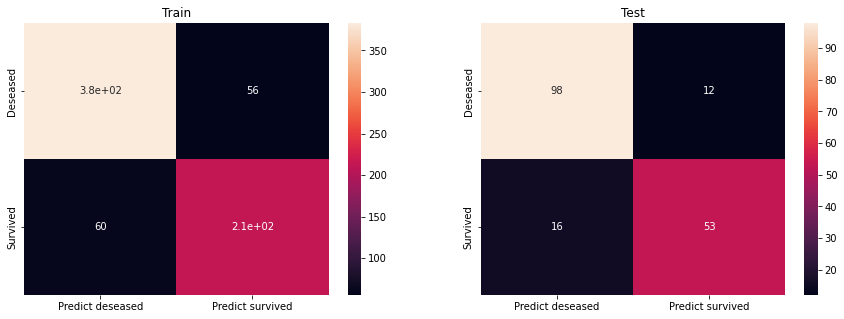

In [184]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train")
ax2.set_title("Test")
sns.heatmap(confusion_matrix(train_result,svc.predict(train_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax1);
sns.heatmap(confusion_matrix(test_result,svc.predict(test_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax2);

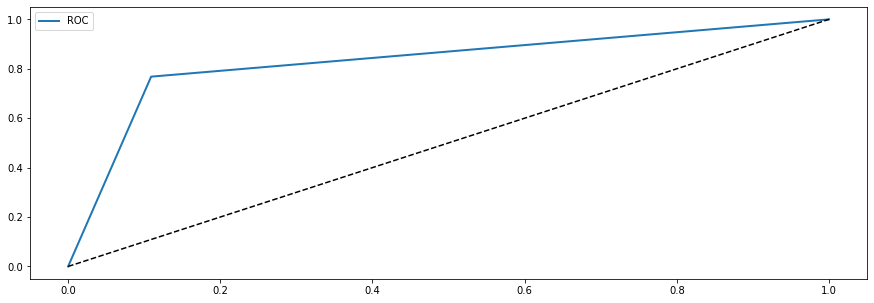

In [161]:
fpr,tpr,thresh = roc_curve(test_result,svc.predict(test_data))
plot_roc(fpr,tpr,"ROC")

In [239]:
print_model_results(svc.predict(test_data),test_result)

Accuracy: 0.8435754189944135
Precision: 0.8153846153846154
Recall: 0.7681159420289855


## Logistic Regression

In [162]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1e3)

In [163]:
log_reg.fit(train_data,train_result)

LogisticRegression(max_iter=1000.0)

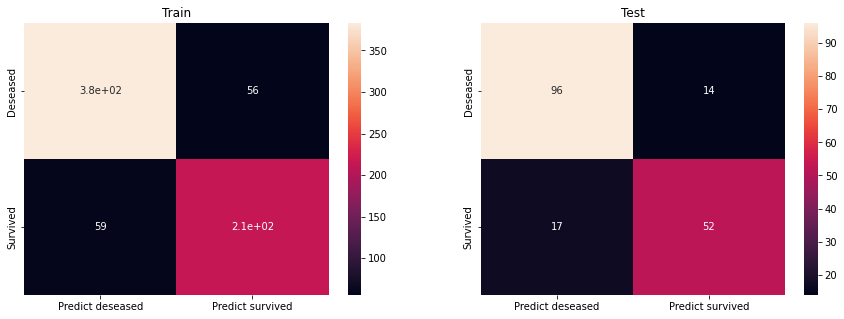

In [183]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train")
ax2.set_title("Test")
sns.heatmap(confusion_matrix(train_result,log_reg.predict(train_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax1);
sns.heatmap(confusion_matrix(test_result,log_reg.predict(test_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax2);

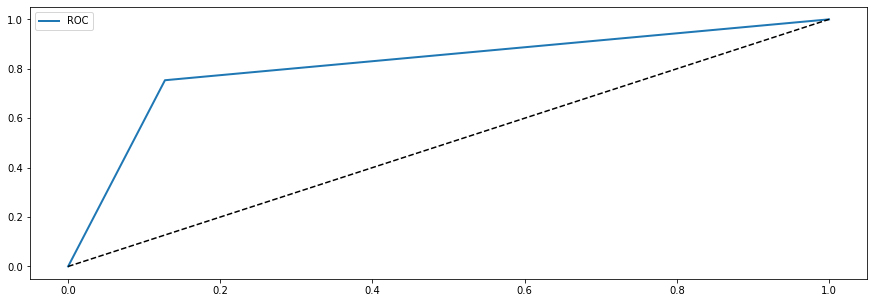

In [169]:
fpr,tpr,thresh = roc_curve(test_result,log_reg.predict(test_data))
plot_roc(fpr,tpr,"ROC")

In [270]:
print_model_results(log_reg.predict(test_data),test_result)

Accuracy: 0.8268156424581006
Precision: 0.7878787878787878
Recall: 0.7536231884057971


## Voting Classifier

In [170]:
from sklearn.ensemble import VotingClassifier

In [194]:
vote = VotingClassifier(estimators=[("svc",svc),("lr",log_reg),("rf",grid_search_rf)])


In [195]:
vote.fit(train_data,train_result)

VotingClassifier(estimators=[('svc', LinearSVC(max_iter=1000000.0)),
                             ('lr', LogisticRegression(max_iter=1000.0)),
                             ('rf',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(max_features=6,
                                                                            n_estimators=10),
                                           param_grid=[{'max_features': [2, 4,
                                                                         6, 8,
                                                                         10, 15,
                                                                         20],
                                                        'n_estimators': [3, 10,
                                                                         15, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70]},
                                                       {'bootstrap': [False],
                                                        'max_features': [2, 3,
                                                                         4, 6,
                                                                         8, 10,
                                                                         12, 14,
                                                                         16, 18,
                                                                         20],
                                                        'n_estimators': [3, 10,
                                                                         15, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70]}],
                                           return_train_score=True,
                                           scoring='accuracy'))])

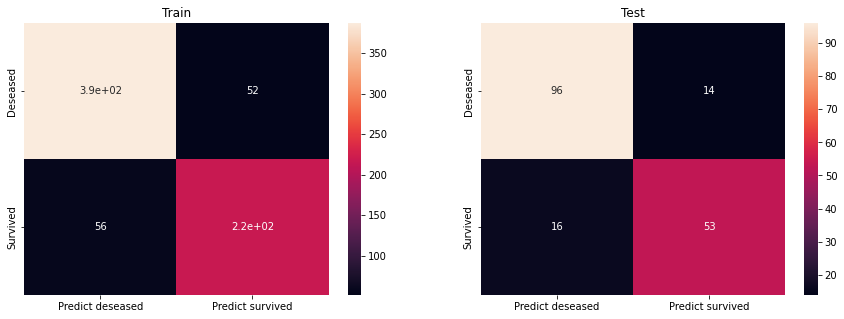

In [196]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train")
ax2.set_title("Test")
sns.heatmap(confusion_matrix(train_result,vote.predict(train_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax1);
sns.heatmap(confusion_matrix(test_result,vote.predict(test_data)),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax2);

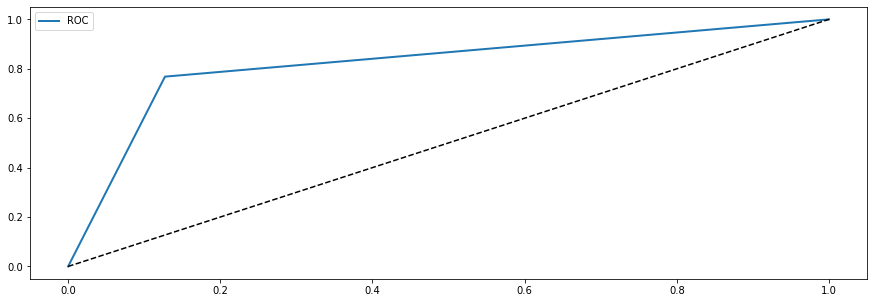

In [247]:
fpr,tpr,thresh = roc_curve(test_result,vote.predict(test_data))
plot_roc(fpr,tpr,"ROC")

In [237]:
print_model_results(vote.predict(test_data),test_result)

Accuracy: 0.8324022346368715
Precision: 0.7910447761194029
Recall: 0.7681159420289855


## Neural Net

### 3 layer

In [210]:
input_ = keras.layers.Input(shape=[train_data.shape[1]])
hidden1 = keras.layers.Dense(100, activation="relu")(input_)
hidden2 = keras.layers.Dense(50, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(25, activation="sigmoid")(hidden2)
#hidden2 = keras.layers.Dense(50, activation="relu")(hidden1) #50
#  hidden3 = keras.layers.Dense(10, activation="sigmoid")(hidden2) # 10
concat = keras.layers.concatenate([input_,hidden3])

output = keras.layers.Dense(1,activation="sigmoid")(concat)
model =keras.models.Model(inputs=[input_],outputs=[output])
model.compile(loss="binary_crossentropy",optimizer="sgd")

In [219]:
train, test = np.zeros(train_data.shape), np.zeros(test_data.shape)
train += train_data
test += test_data

In [281]:
cut = len(train)-int(np.floor(len(train)*0.8))
train_tmp, train_result_tmp = train[:cut], train_result[:cut]
val, val_result = train[cut:],train_result[cut:]

In [282]:
history = model.fit(train_tmp,train_result_tmp,batch_size=20,epochs=150, validation_data=(val,val_result));

Epoch 1/150
8/8 [==============================] - 0s 6ms/step - loss: 0.4898 - val_loss: 1.2982
Epoch 2/150
8/8 [==============================] - 0s 3ms/step - loss: 0.6781 - val_loss: 0.4119
Epoch 3/150
8/8 [==============================] - 0s 3ms/step - loss: 0.5210 - val_loss: 0.4052
Epoch 4/150
8/8 [==============================] - 0s 3ms/step - loss: 0.5168 - val_loss: 1.8066
Epoch 5/150
8/8 [==============================] - 0s 3ms/step - loss: 0.6840 - val_loss: 0.5378
Epoch 6/150
8/8 [==============================] - 0s 3ms/step - loss: 0.5762 - val_loss: 0.3828
Epoch 7/150
8/8 [==============================] - 0s 3ms/step - loss: 0.4866 - val_loss: 0.3872
Epoch 8/150
8/8 [==============================] - 0s 3ms/step - loss: 0.5000 - val_loss: 0.4300
Epoch 9/150
8/8 [==============================] - 0s 3ms/step - loss: 0.4862 - val_loss: 0.3839
Epoch 10/150
8/8 [==============================] - 0s 2ms/step - loss: 0.4775 - val_loss: 0.3971
Epoch 11/150
8/8 [===========

In [221]:
def plot_train(his):
  his_ = pd.DataFrame(his.history)
  his_["loss"] = his_["loss"]
  his_["val_loss"] = his_["val_loss"]

  his_.plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.title("Learning Rate")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

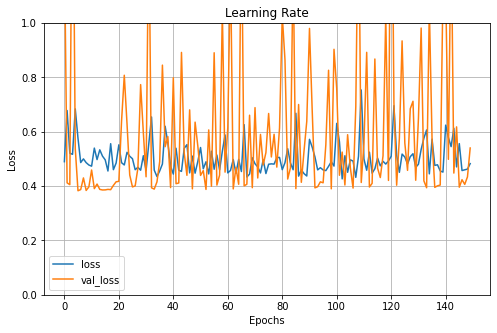

In [283]:
plot_train(history)

23/23 [==============================] - 0s 909us/step


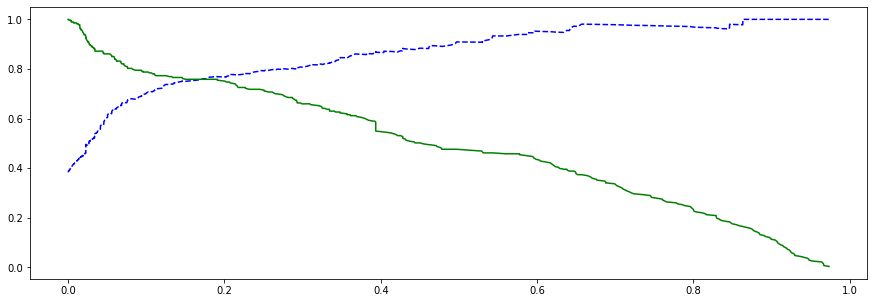

In [284]:
prec, rec, thresh = precision_recall_curve(train_result,model.predict(train_data))
plot_prec_recall(prec,rec,thresh)

In [285]:
def convert_to_binary(model,data,thresh):
    results = []
    tmp = model.predict(data,verbose=0)
    for i in range(len(tmp)):
    
        if model.predict(data)[i] >= thresh:
            results.append(1)
        else:
            results.append(0)
    return results
results = convert_to_binary(model,test_data,0.2)
results_train = convert_to_binary(model,train_data,0.2)


#sns.heatmap(confusion_matrix(test_result,model.predict(test_data)),annot=True)

23/23 [==============================] - 0s 398us/step


23/23 [==============================] - 0s 369us/step


23/23 [==============================] - 0s 377us/step


23/23 [==============================] - 0s 372us/step


23/23 [==============================] - 0s 380us/step


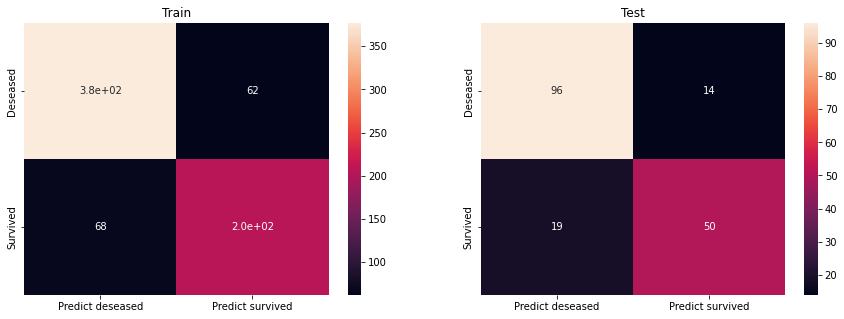

In [286]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Train")
ax2.set_title("Test")
sns.heatmap(confusion_matrix(train_result,results_train),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax1);
sns.heatmap(confusion_matrix(test_result,results),
            xticklabels=["Predict deseased","Predict survived"],
            yticklabels=["Deseased","Survived"],
            annot=True,ax=ax2);

6/6 [==============================] - 0s 2ms/step


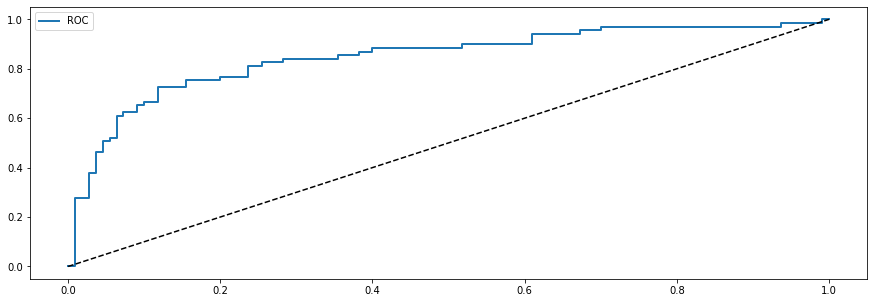

In [287]:
fpr,tpr,thresh = roc_curve(test_result,model.predict(test_data))
plot_roc(fpr,tpr,"ROC")

In [288]:
print_model_results(results,test_result)

Accuracy: 0.8156424581005587
Precision: 0.78125
Recall: 0.7246376811594203


# Summary

6/6 [==============================] - 0s 779us/step


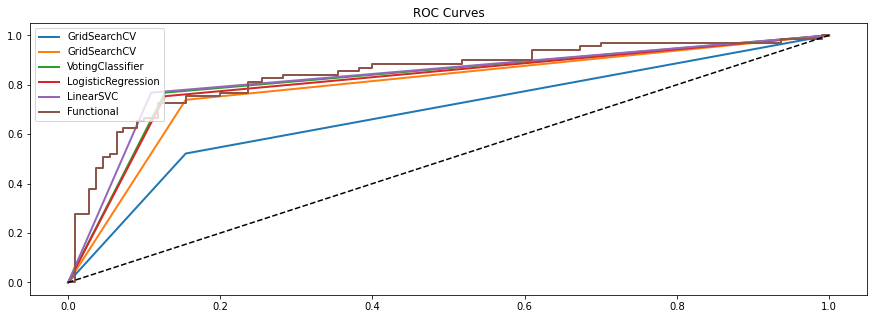

In [290]:
model_list=[grid_search,grid_search_rf,vote,log_reg,svc,model]
def plot_many_roc(model_list):
    for model in model_list:
        fpr,tpr,thresh = roc_curve(test_result,model.predict(test_data))
        plt.plot(fpr,tpr,linewidth=2,label=type(model).__name__)
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc='upper left')
    plt.title("ROC Curves")
    plt.show()
plot_many_roc(model_list)

In [289]:
model_list=[grid_search,grid_search_rf,vote,log_reg,svc]
acc, recall, precision = [],[],[]
for mod in model_list:
    acc.append( accuracy_score(test_result,mod.predict(test_data)))
    recall.append(recall_score(test_result,mod.predict(test_data)))
    precision.append(precision_score(test_result,mod.predict(test_data)))
model_list.append(model)
acc.append(accuracy_score(results,test_result))
recall.append(recall_score(results,test_result))
precision.append(precision_score(results,test_result))

In [291]:
index_ = np.argsort(acc)
print("Accuracy Scores:")
for i in index_:
    print(type(model_list[i]).__name__,acc[i])

Accuracy Scores:
GridSearchCV 0.7206703910614525
GridSearchCV 0.8044692737430168
Functional 0.8156424581005587
LogisticRegression 0.8268156424581006
VotingClassifier 0.8324022346368715
LinearSVC 0.8435754189944135


In [292]:
index_ = np.argsort(recall)
print("Recall Scores:")
for i in index_:
    print(type(model_list[i]).__name__,recall[i])

Recall Scores:
GridSearchCV 0.5217391304347826
GridSearchCV 0.7391304347826086
LogisticRegression 0.7536231884057971
VotingClassifier 0.7681159420289855
LinearSVC 0.7681159420289855
Functional 0.78125


In [293]:
index_ = np.argsort(precision)
print("Precision Scores:")
for i in index_:
    print(type(model_list[i]).__name__,precision[i])

Precision Scores:
GridSearchCV 0.6792452830188679
Functional 0.7246376811594203
GridSearchCV 0.75
LogisticRegression 0.7878787878787878
VotingClassifier 0.7910447761194029
LinearSVC 0.8153846153846154


It appears (generally speaking) the support vector classifier had the most success with the highest accuracy 